In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install gymnasium[atari] gymnasium[accept-rom-license] torch numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.6 MB/s

Usando dispositivo: cuda


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Actualización PPO completada en paso 2000
Actualización PPO completada en paso 4000
Actualización PPO completada en paso 6000
Actualización PPO completada en paso 8000
Actualización PPO completada en paso 10000
Episodio 10 	 Promedio Score: 396.00 	 Pasos Totales: 10336
Actualización PPO completada en paso 12000
Actualización PPO completada en paso 14000
Actualización PPO completada en paso 16000
Actualización PPO completada en paso 18000
Actualización PPO completada en paso 20000
Modelo guardado: PPO_Gopher_20000.pth
Episodio 20 	 Promedio Score: 542.00 	 Pasos Totales: 21229
Actualización PPO completada en paso 22000
Actualización PPO completada en paso 24000
Actualización PPO completada en paso 26000
Actualización PPO completada en paso 28000
Actualización PPO completada en paso 30000
Episodio 30 	 Promedio Score: 402.00 	 Pasos Totales: 31463
Actualización PPO completada en paso 32000
Actualización PPO completada en paso 34000
Actualización PPO completada en paso 36000
Actualizació

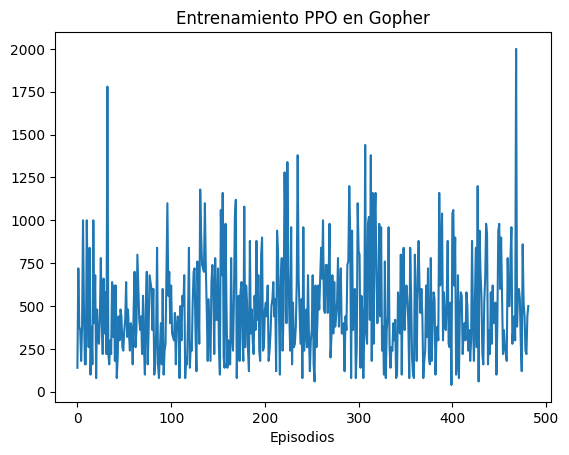

In [3]:
# 1. Configuración e Importaciones
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.wrappers import AtariPreprocessing, FrameStack, TransformReward

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 2. Hiperparámetros (Ajustados para PPO/Atari)
LR = 2.5e-4             # Tasa de aprendizaje más baja para estabilidad
GAMMA = 0.99            # Descuento
EPS_CLIP = 0.2          # El "freno" de PPO para no cambiar demasiado la política
K_EPOCHS = 4            # Cuántas veces re-entrenamos con los mismos datos
UPDATE_TIMESTEP = 2000  # Actualizar cada 2000 pasos de juego
MAX_TIMESTEPS = 500000  # Total de pasos (En Atari real suelen ser millones)

# 3. Entorno de RL (Con Wrappers de Visión)
def make_env():
    # Usamos NoFrameskip para tener control total
    env = gym.make("GopherNoFrameskip-v4", render_mode="rgb_array")
    # AtariPreprocessing hace la magia: Grayscale, Resize a 84x84
    env = AtariPreprocessing(env, scale_obs=True, grayscale_obs=True, frame_skip=4)
    # FrameStack: Apila 4 cuadros para que el agente vea "movimiento"
    env = FrameStack(env, num_stack=4)
    return env

env = make_env()
# La entrada ahora es (4 frames, 84 alto, 84 ancho)
state_dim = env.observation_space.shape 
action_dim = env.action_space.n



class ActorCritic(nn.Module):
    def __init__(self, action_dim):
        super(ActorCritic, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.feature_size = 64 * 7 * 7 
        
        self.actor = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim),
            nn.Softmax(dim=-1)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def act(self, state):
        # --- CORRECCIÓN AQUÍ ---
        # Forzamos la conversión de LazyFrames a numpy array real
        state = np.array(state) 
        
        # Ahora sí podemos preguntar por ndim con seguridad
        if state.ndim == 3: state = np.expand_dims(state, 0)
        
        state = torch.from_numpy(state).float().to(device)
        
        features = self.features(state)
        action_probs = self.actor(features)
        dist = Categorical(action_probs)
        
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.item(), action_logprob.item()

    def evaluate(self, state, action):
        # Aquí state ya viene del buffer como numpy array, pero por seguridad
        # PyTorch lo maneja bien si ya lo convertimos antes de guardarlo.
        features = self.features(state)
        action_probs = self.actor(features)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(features)
        
        return action_logprobs, state_values, dist_entropy


# Inicializar modelo
policy = ActorCritic(action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=LR)
# Necesitamos una copia vieja de la política para PPO
policy_old = ActorCritic(action_dim).to(device)
policy_old.load_state_dict(policy.state_dict())

# 7. Búfer de Reproducción (Rollout Buffer)
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

buffer = RolloutBuffer()

# 9. Entrenamiento del Agente (Lógica PPO)
def update():
    # Calcular Monte Carlo estimate de returns
    rewards = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(buffer.rewards), reversed(buffer.is_terminals)):
        if is_terminal:
            discounted_reward = 0
        discounted_reward = reward + (GAMMA * discounted_reward)
        rewards.insert(0, discounted_reward)
        
    # Normalizar rewards
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

    # Convertir lista a tensores
    old_states = torch.tensor(np.array(buffer.states), dtype=torch.float32).to(device)
    old_actions = torch.tensor(buffer.actions, dtype=torch.float32).to(device)
    old_logprobs = torch.tensor(buffer.logprobs, dtype=torch.float32).to(device)

    # Optimizar política por K épocas
    for _ in range(K_EPOCHS):
        # Evaluar acciones viejas y valores
        logprobs, state_values, dist_entropy = policy.evaluate(old_states, old_actions)
        
        # Ratio de importancia (pi_theta / pi_theta_old)
        ratios = torch.exp(logprobs - old_logprobs.detach())

        # Surrogate Loss de PPO (La parte mágica de PPO)
        advantages = rewards - state_values.detach().squeeze()
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1-EPS_CLIP, 1+EPS_CLIP) * advantages
        
        # Loss total: Actor + Critico - Exploración (Entropía)
        loss = -torch.min(surr1, surr2) + 0.5*nn.MSELoss()(state_values.squeeze(), rewards) - 0.01*dist_entropy
        
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
    # Copiar nuevos pesos a la política vieja
    policy_old.load_state_dict(policy.state_dict())
    buffer.clear()

# ==========================================
# Bucle Principal de Entrenamiento
# ==========================================

time_step = 0
i_episode = 0
scores = []

# Loop hasta alcanzar MAX_TIMESTEPS
while time_step < MAX_TIMESTEPS:
    state, _ = env.reset()
    current_ep_reward = 0
    
    # 8. Recopilación de datos
    while True:
        # Seleccionar acción con la política vieja
        action, log_prob = policy_old.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        
        # Guardar en buffer
        buffer.states.append(state)
        buffer.actions.append(action)
        buffer.logprobs.append(log_prob)
        buffer.rewards.append(reward)
        buffer.is_terminals.append(done or truncated)
        
        time_step += 1
        current_ep_reward += reward
        state = next_state



        
        # 9. Actualizar PPO si llenamos el buffer
        if time_step % UPDATE_TIMESTEP == 0:
            update()
            print(f"Actualización PPO completada en paso {time_step}")

            
            # --- CÓDIGO NUEVO: GUARDAR MODELO CADA 20,000 PASOS ---
            if time_step % 20000 == 0:
                torch.save(policy.state_dict(), f'PPO_Gopher_{time_step}.pth')
                print(f"Modelo guardado: PPO_Gopher_{time_step}.pth")


            
        if done or truncated:
            break
    
    scores.append(current_ep_reward)
    i_episode += 1
    
    if i_episode % 10 == 0:
        avg_score = np.mean(scores[-10:])
        print(f"Episodio {i_episode} \t Promedio Score: {avg_score:.2f} \t Pasos Totales: {time_step}")

# 10. Visualización básica
plt.plot(scores)
plt.title("Entrenamiento PPO en Gopher")
plt.xlabel("Episodios")
plt.show()

--- INICIANDO ENTRENAMIENTO DE LARGA DURACIÓN: 5000000 PASOS ---
Puedes cerrar el navegador si estás ejecutando esto como 'Save Version' (Commit)
Episodio 20 | Pasos: 20768/5000000 | Score Promedio: 440.00
Episodio 40 | Pasos: 42055/5000000 | Score Promedio: 438.00
Episodio 60 | Pasos: 64101/5000000 | Score Promedio: 506.00
Episodio 80 | Pasos: 85004/5000000 | Score Promedio: 458.00
Episodio 100 | Pasos: 104921/5000000 | Score Promedio: 510.00
Episodio 120 | Pasos: 126381/5000000 | Score Promedio: 507.00
Episodio 140 | Pasos: 148305/5000000 | Score Promedio: 538.00
Episodio 160 | Pasos: 169803/5000000 | Score Promedio: 434.00
Episodio 180 | Pasos: 190263/5000000 | Score Promedio: 465.00
Episodio 200 | Pasos: 209767/5000000 | Score Promedio: 434.00
Episodio 220 | Pasos: 231608/5000000 | Score Promedio: 519.00
Episodio 240 | Pasos: 251905/5000000 | Score Promedio: 389.00
Episodio 260 | Pasos: 272375/5000000 | Score Promedio: 450.00
Episodio 280 | Pasos: 294094/5000000 | Score Promedio: 5

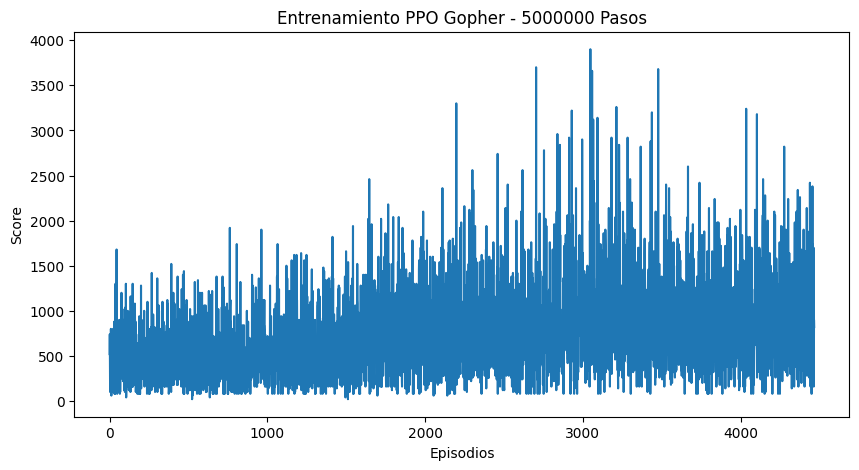

In [4]:
import os

# --- CONFIGURACIÓN PARA LARGA DURACIÓN ---
MAX_TIMESTEPS = 5000000  # 5 Millones (La meta de oro)
UPDATE_TIMESTEP = 2000   # Actualizar PPO cada 2000 pasos
SAVE_FREQ = 500000       # Guardar backup cada 500k pasos

print(f"--- INICIANDO ENTRENAMIENTO DE LARGA DURACIÓN: {MAX_TIMESTEPS} PASOS ---")
print("Puedes cerrar el navegador si estás ejecutando esto como 'Save Version' (Commit)")

# Reiniciamos contadores para el loop largo
time_step = 0
i_episode = 0
scores = []

# Aseguramos que el modelo esté en modo entrenamiento
policy.train()

while time_step < MAX_TIMESTEPS:
    state, _ = env.reset()
    current_ep_reward = 0
    
    while True:
        # 1. Seleccionar acción
        action, log_prob = policy_old.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        
        # 2. Guardar en buffer
        buffer.states.append(state)
        buffer.actions.append(action)
        buffer.logprobs.append(log_prob)
        buffer.rewards.append(reward)
        buffer.is_terminals.append(done or truncated)
        
        time_step += 1
        current_ep_reward += reward
        state = next_state
        
        # 3. Actualizar PPO
        if time_step % UPDATE_TIMESTEP == 0:
            update()
            
        # 4. GUARDADO DE SEGURIDAD (CHECKPOINTS)
        if time_step % SAVE_FREQ == 0:
            # Guardar un checkpoint específico (ej: PPO_Gopher_1M.pth)
            torch.save(policy.state_dict(), f'PPO_Gopher_{time_step}.pth')
            print(f"--> Checkpoint guardado: PPO_Gopher_{time_step}.pth")
            
        # Guardar siempre el "último modelo" por si se corta en el paso 4.9M
        if time_step % 50000 == 0:
             torch.save(policy.state_dict(), 'PPO_Gopher_LATEST.pth')

        if done or truncated:
            break
    
    scores.append(current_ep_reward)
    i_episode += 1
    
    # Reporte ligero para no llenar el log
    if i_episode % 20 == 0:
        avg_score = np.mean(scores[-20:])
        print(f"Episodio {i_episode} | Pasos: {time_step}/{MAX_TIMESTEPS} | Score Promedio: {avg_score:.2f}")

print("¡ENTRENAMIENTO FINALIZADO!")
# Guardado final
torch.save(policy.state_dict(), 'PPO_Gopher_FINAL_5M.pth')

# Visualización final del progreso
plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title(f"Entrenamiento PPO Gopher - {MAX_TIMESTEPS} Pasos")
plt.xlabel("Episodios")
plt.ylabel("Score")
plt.savefig("grafico_entrenamiento_completo.png") # Guardamos la imagen también
plt.show()

In [5]:
# Instalación de dependencias del sistema (si no se hizo antes)
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

from pyvirtualdisplay import Display
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
import gymnasium as gym
# Importamos los mismos wrappers que usamos en el entrenamiento
from gymnasium.wrappers import AtariPreprocessing, FrameStack

# 1. Iniciar pantalla virtual
# Necesitamos una pantalla más grande para Atari a veces
virtual_display = Display(visible=0, size=(1400, 900)) 
virtual_display.start()

In [6]:
# 2. Configurar entorno para grabación EXACTAMENTE como el de entrenamiento
# render_mode="rgb_array" es vital para grabar
env_to_record = gym.make("GopherNoFrameskip-v4", render_mode="rgb_array")

# --- APLICAMOS LOS MISMOS PREPROCESADORES ---
env_to_record = AtariPreprocessing(env_to_record, scale_obs=True, grayscale_obs=True, frame_skip=4)
env_to_record = FrameStack(env_to_record, num_stack=4)

# Ahora sí, el wrapper de video
env_to_record = RecordVideo(env_to_record, video_folder="./video_atari_result", episode_trigger=lambda x: True, name_prefix="ppo-gopher")

# 3. Correr un episodio con el agente entrenado
# Usamos policy_old porque es la que usamos para inferencia (act)
policy_old.eval() # Ponemos el modelo en modo evaluación (opcional pero buena práctica)

state, _ = env_to_record.reset()
done = False
truncated = False
total_reward = 0
step_counter = 0

print("Grabando episodio... esto puede tomar unos segundos...")

while not done and not truncated:
    # Usamos la función .act() de tu clase ActorCritic
    # Ya incluye la corrección de np.array(state) que hicimos antes.
    action, _ = policy_old.act(state)
    
    state, reward, done, truncated, _ = env_to_record.step(action)
    total_reward += reward
    step_counter += 1
    
    # Límite de seguridad por si el agente es muy bueno y nunca pierde
    if step_counter > 50000: 
        print("Límite de pasos de grabación alcanzado.")
        break

env_to_record.close()
policy_old.train() # Devolvemos el modelo a modo entrenamiento por si acaso
print(f"¡Juego grabado! Recompensa total del episodio: {total_reward}. Pasos: {step_counter}")

/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Grabando episodio... esto puede tomar unos segundos...


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /kaggle/working/video_atari_result/ppo-gopher-episode-0.mp4.
Moviepy - Writing video /kaggle/working/video_atari_result/ppo-gopher-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/video_atari_result/ppo-gopher-episode-0.mp4
¡Juego grabado! Recompensa total del episodio: 680.0. Pasos: 1171


In [7]:
def show_video_atari():
    # Buscamos en la carpeta que definimos arriba
    mp4list = glob.glob('video_atari_result/*.mp4')
    if len(mp4list) > 0:
        # Tomamos el último video generado
        mp4 = sorted(mp4list, key=os.path.getmtime)[-1]
        print(f"Mostrando video: {mp4}")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        return HTML(data='''<video alt="Atari Recording" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
    else:
        print("No se encontró el video en video_atari_result/")

# Necesitamos importar os para ordenar por fecha
import os 
show_video_atari()

Mostrando video: video_atari_result/ppo-gopher-episode-0.mp4
